The following code will be to try to reproduce or follow along with the code provided in this article: https://medium.com/@abbasbehrain95/creating-an-ai-powered-job-recommendation-system-50ce1cd12d36

In [ ]:
!pip install selenium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.2/467.2 kB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.4 MB/s eta 0:00:00


In [ ]:
!pip install chromium

In [ ]:
# jd_data_extractor.py

import pandas as pd
from tqdm import tqdm
from time import sleep
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from bs4 import BeautifulSoup
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.common.exceptions import NoSuchElementException
import json
import urllib
import time

driver = web_driver()

def openbrowser(locid, key):
    driver.wait = WebDriverWait(driver, 5)
    driver.maximize_window()
    words = key.split()
    txt =''
    for w in words:
        txt +=(w+'+')
    #print (txt)
    driver.get("https://www.glassdoor.co.in/Job/jobs.htm?suggestCount=0&suggestChosen=true&clickSource=searchBtn&typedKeyword={}"
           "&sc.keyword={}&locT=C&locId={}&jobType=fulltime&fromAge=1&radius=6&cityId=-1&minRating=0.0&industryId=-1"
           "&sgocId=-1&companyId=-1&employerSizes=0&applicationType=0&remoteWorkType=0".format(txt[:-1], txt[:-1], locid))

    return driver

def geturl(driver):
    url = set()
    while True:
        print(len(url))
        if len(url)>=20:
            break
        soup1 = BeautifulSoup(driver.page_source, "lxml")

        main = soup1.find_all("li",{"class":"jl"})

        for m in main:
            url.add('https://www.glassdoor.co.in{}'.format(m.find('a')['href']))
        try:
            next_element = soup1.find("li", {"class": "next"})
            try:
                next_exist = next_element.find('a')
            except AttributeError:
                driver.quit()
                break
            except NoSuchElementException:
                driver.quit()
                break
            if next_exist:

                driver.find_element_by_class_name("next").click()
                time.sleep(2)
            else:
                driver.quit()
                break
        except ElementClickInterceptedException:
            pass

    return list(url)

x =openbrowser(locid =4477468, key='"Data Scientist"')
with open('url_data_scientist_loc_bangalore.json','w') as f:
    json.dump(geturl(driver),f, indent = 4)
    print("file created")

with open('url_data_scientist_loc_bangalore.json','r') as f:
    url = json.load(f)
data ={}
i = 1
jd_df = pd.DataFrame()
driver = web_driver()

for u in tqdm(url):
    driver.wait = WebDriverWait(driver, 2)
    driver.maximize_window()
    driver.get(u)
    soup = BeautifulSoup(driver.page_source, "lxml")
    try:

        header = soup.find("div",{"class":"header cell info"})
        position = driver.find_element_by_tag_name('h2').text
        company = driver.find_element_by_xpath("//span[@class='strong ib']").text
        location = driver.find_element_by_xpath("//span[@class='subtle ib']").text
        jd_temp = driver.find_element_by_id("JobDescriptionContainer")
        jd = jd_temp.text
        info = soup.find_all("infoEntity")
    except IndexError:
        print('IndexError: list index out of range')
    except NoSuchElementException:
        pass
    data[i] = {
        'url' :u,
        'Position':position,
        'Company': company,
        'Location' :location,
        'Job_Description' :jd
    }
    i+=1

print(data)
driver.quit()
jd_df = pd.DataFrame(data)
jd = jd_df.transpose()


print(jd)
jd = jd[['url','Position','Company','Location','Job_Description']]
jd.to_csv('jd_unstructured_data.csv')
print('file created')


def get_jobs(keyword, num_jobs, verbose, path, slp_time):

    '''Gathers jobs as a dataframe, scraped from Glassdoor'''

    #Initializing the webdriver
    options = webdriver.ChromeOptions()

    #Uncomment the line below if you'd like to scrape without a new Chrome window every time.
    #options.add_argument('headless')

    #Change the path to where chromedriver is in your home folder.
    driver = web_driver()
    driver.set_window_size(1120, 1000)

    url = "https://www.glassdoor.com/Job/jobs.htm?suggestCount=0&suggestChosen=false&clickSource=searchBtn&typedKeyword="+keyword+"&sc.keyword="+keyword+"&locT=&locId=&jobType="
    #url = 'https://www.glassdoor.com/Job/jobs.htm?sc.keyword="' + keyword + '"&locT=C&locId=1147401&locKeyword=San%20Francisco,%20CA&jobType=all&fromAge=-1&minSalary=0&includeNoSalaryJobs=true&radius=100&cityId=-1&minRating=0.0&industryId=-1&sgocId=-1&seniorityType=all&companyId=-1&employerSizes=0&applicationType=0&remoteWorkType=0'
    driver.get(url)
    jobs = []

    while len(jobs) < num_jobs:  #If true, should be still looking for new jobs.

        #Let the page load. Change this number based on your internet speed.
        #Or, wait until the webpage is loaded, instead of hardcoding it.
        time.sleep(slp_time)

        #Test for the "Sign Up" prompt and get rid of it.
        try:
            driver.find_element_by_class_name("selected").click()
        except ElementClickInterceptedException:
            pass

        time.sleep(.1)

        try:
            driver.find_element_by_css_selector('[alt="Close"]').click() #clicking to the X.
            print(' x out worked')
        except NoSuchElementException:
            print(' x out failed')
            pass


        #Going through each job in this page
        job_buttons = driver.find_elements_by_class_name("jl")  #jl for Job Listing. These are the buttons we're going to click.
        for job_button in job_buttons:

            print("Progress: {}".format("" + str(len(jobs)) + "/" + str(num_jobs)))
            if len(jobs) >= num_jobs:
                break

            job_button.click()  #You might
            time.sleep(1)
            collected_successfully = False

            while not collected_successfully:
                try:
                    company_name = driver.find_element_by_xpath('.//div[@class="employerName"]').text
                    location = driver.find_element_by_xpath('.//div[@class="location"]').text
                    job_title = driver.find_element_by_xpath('.//div[contains(@class, "title")]').text
                    job_description = driver.find_element_by_xpath('.//div[@class="jobDescriptionContent desc"]').text
                    collected_successfully = True
                except:
                    time.sleep(5)

            try:
                salary_estimate = driver.find_element_by_xpath('.//span[@class="gray salary"]').text
            except NoSuchElementException:
                salary_estimate = -1 #You need to set a "not found value. It's important."

            try:
                rating = driver.find_element_by_xpath('.//span[@class="rating"]').text
            except NoSuchElementException:
                rating = -1 #You need to set a "not found value. It's important."

            #Printing for debugging
            if verbose:
                print("Job Title: {}".format(job_title))
                print("Salary Estimate: {}".format(salary_estimate))
                print("Job Description: {}".format(job_description[:500]))
                print("Rating: {}".format(rating))
                print("Company Name: {}".format(company_name))
                print("Location: {}".format(location))

            #Going to the Company tab...
            #clicking on this:
            #<div class="tab" data-tab-type="overview"><span>Company</span></div>
            try:
                driver.find_element_by_xpath('.//div[@class="tab" and @data-tab-type="overview"]').click()

                try:
                    #<div class="infoEntity">
                    #    <label>Headquarters</label>
                    #    <span class="value">San Francisco, CA</span>
                    #</div>
                    headquarters = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Headquarters"]//following-sibling::*').text
                except NoSuchElementException:
                    headquarters = -1

                try:
                    size = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Size"]//following-sibling::*').text
                except NoSuchElementException:
                    size = -1

                try:
                    founded = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Founded"]//following-sibling::*').text
                except NoSuchElementException:
                    founded = -1

                try:
                    type_of_ownership = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Type"]//following-sibling::*').text
                except NoSuchElementException:
                    type_of_ownership = -1

                try:
                    industry = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Industry"]//following-sibling::*').text
                except NoSuchElementException:
                    industry = -1

                try:
                    sector = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Sector"]//following-sibling::*').text
                except NoSuchElementException:
                    sector = -1

                try:
                    revenue = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Revenue"]//following-sibling::*').text
                except NoSuchElementException:
                    revenue = -1

                try:
                    competitors = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Competitors"]//following-sibling::*').text
                except NoSuchElementException:
                    competitors = -1

            except NoSuchElementException:  #Rarely, some job postings do not have the "Company" tab.
                headquarters = -1
                size = -1
                founded = -1
                type_of_ownership = -1
                industry = -1
                sector = -1
                revenue = -1
                competitors = -1


            if verbose:
                print("Headquarters: {}".format(headquarters))
                print("Size: {}".format(size))
                print("Founded: {}".format(founded))
                print("Type of Ownership: {}".format(type_of_ownership))
                print("Industry: {}".format(industry))
                print("Sector: {}".format(sector))
                print("Revenue: {}".format(revenue))
                print("Competitors: {}".format(competitors))

            jobs.append({"Job Title" : job_title,
            "Salary Estimate" : salary_estimate,
            "Job Description" : job_description,
            "Rating" : rating,
            "Company Name" : company_name,
            "Location" : location,
            "Headquarters" : headquarters,
            "Size" : size,
            "Founded" : founded,
            "Type of ownership" : type_of_ownership,
            "Industry" : industry,
            "Sector" : sector,
            "Revenue" : revenue,
            "Competitors" : competitors})
            #add job to jobs


        #Clicking on the "next page" button
        try:
            driver.find_element_by_xpath('.//li[@class="next"]//a').click()
        except NoSuchElementException:
            print("Scraping terminated before reaching target number of jobs. Needed {}, got {}.".format(num_jobs, len(jobs)))
            break

    return pd.DataFrame(jobs)  #This line converts the dictionary object into a pandas DataFrame.

    #path = r"C:\Users\Admin\ML_Projects\Job_Recommendation_System\Job-Recommendation-System\chromedriver_win32\chromedriver.exe"

unstructured_data_df = get_jobs('data scientist',1000, False, driver, 15)

unstructured_data_df.to_csv('jd_unstructured_data.csv', index = False)

0
file created


0it [00:00, ?it/s]

{}
Empty DataFrame
Columns: []
Index: []


KeyError: "None of [Index(['url', 'Position', 'Company', 'Location', 'Job_Description'], dtype='object')] are in the [columns]"

I changed the paths for the jd_unstructured_data.csv file that was in the original code provided by Behrain but otherwise left everything unchanged. I get an error on instantiation of the web driver, so I remove the argument the executable_path argument from inside Chrome() and just call Chrome(). Now I get the following error:

SessionNotCreatedException: Message: session not created: Chrome failed to start: exited normally.
  (session not created: DevToolsActivePort file doesn't exist)
  (The process started from chrome location /root/.cache/selenium/chrome/linux64/123.0.6312.105/chrome is no longer running, so ChromeDriver is assuming that Chrome has crashed.)

I remember running into hurdles getting a Selenium Chrome Webdriver working with Colab before, and I remember the following video helping me to get things working, so I am re-visiting it: https://www.youtube.com/watch?v=VSO14hgo6Gs&t=67s

In [ ]:
!apt-get update
!apt-get install chromium chromium-driver

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [61.2 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,358 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/rest

In [ ]:
def web_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--verbose")
    options.add_argument('--no-sandbox')
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument("--window-size=1920, 1200")
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)
    return driver

Now after defining the above function, I instantiate driver in the provided code instead with web_driver().

In [ ]:
# jd_data_cleaner.py

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
stopw  = set(stopwords.words('english'))

# Load the dataset:
unstructured_df=pd.read_csv('jd_unstructured_data.csv')

def convert_salary(value):
    if 'Unknown' in value:
        return None
    elif '-' in value:
        values = re.findall(r'\$\d+K', value)
        min_value = int(values[0].replace('$', '').replace('K', '')) if values else None
        max_value = int(values[1].replace('$', '').replace('K', '')) if len(values) > 1 else None
        if min_value and max_value:
            return (min_value + max_value) / 2
        elif min_value:
            return min_value
        elif max_value:
            return max_value
        else:
            return None
    else:
        return int(re.findall(r'\$\d+K', value)[0].replace('$', '').replace('K', ''))

def convert_revenue(value):
    if 'Unknown' in value:
        return None
    elif ' to ' in value:
        values = re.findall(r'\d+\.?\d*', value)
        min_revenue = float(values[0])
        max_revenue = float(values[1])
        unit = value.split()[-2]
        if unit == 'billion':
            min_revenue *= 1000
            max_revenue *= 1000
        return (min_revenue + max_revenue) / 2
    else:
        numerical_values = re.findall(r'\d+\.?\d*', value)
        if numerical_values:
            return float(numerical_values[0])
        else:
            return None

# Define a function to convert the size value
def convert_size(value):
    if 'Unknown' in value:
        return None
    elif ' to ' in value:
        sizes = value.split(' to ')
        min_size = int(sizes[0].replace('+', '').replace(',', '').split()[0])
        max_size = int(sizes[1].replace('+', '').replace(',', '').split()[0])
        return (min_size + max_size) / 2
    else:
        return int(value.replace('+', '').replace(',', '').split()[0])

# Apply the conversion function to the "Salary Column" column
unstructured_df['Average Salary'] = unstructured_df['Salary Estimate'].apply(convert_salary)

# Apply the conversion function to the "Revenue" column
unstructured_df['Average Revenue'] = unstructured_df['Revenue'].apply(convert_revenue)

# Extract the company name by splitting on '\r\n' and selecting the first element
unstructured_df['Company Name'] = unstructured_df['Company Name'].str.split('\r\n').str[0]


# Apply the conversion function to the "Size" column
unstructured_df['Size'] = unstructured_df['Size'].apply(convert_size)

# remove stopwords and pre-process Job Description Column:
unstructured_df['Processed_JD']=unstructured_df['Job Description'].apply(lambda x: ' '.join([word for word in str(x).split() if len(word)>2 and word not in (stopw)]))


# Drop Unwanted Columns:
unstructured_df=unstructured_df.drop(['Unnamed: 0','Salary Estimate','Revenue','Job Description'],axis=1)

# Check for Null Value after data pre-processing:
unstructured_df.isnull().sum()

# Replace the null values with average value of each columns:
# Calculate the average value of column B
size_average = unstructured_df['Size'].mean()
salary_average=unstructured_df['Average Salary'].mean()
revenue_average=unstructured_df['Average Revenue'].mean()

# Replace null values with the average
unstructured_df['Size'].fillna(size_average, inplace=True)
unstructured_df['Average Salary'].fillna(salary_average, inplace=True)
unstructured_df['Average Revenue'].fillna(revenue_average, inplace=True)

# Convert DataFrame to CSV file
unstructured_df.to_csv(r'C:\Users\Admin\ML_Projects\Job_Recommendation_System\Job-Recommendation-System\src\data\jd_structured_data.csv', index=False)

So far I have been unable to get the provided code to work even after trying a few things to get over this hump. If I can't get things working in a reasonable amount of time I will move onto discussing what was learned from the article.  

I'm going to try to execute some of the code provided by Preston Lam in this Github Repo to follow along. He built a resume matching and topic modeling job recommendation system based off Glassdoor Jobs Data.

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import pickle


def tokenize_stem(series):

    tokenizer =TreebankWordTokenizer()
    stemmer = PorterStemmer()
    series = series.apply(lambda x: x.replace("\n", ' '))
    series = series.apply(lambda x: tokenizer.tokenize(x))
    series = series.apply(lambda x: [stemmer.stem(w) for w in x])
    series = series.apply(lambda x: ' '.join(x))
    return series

def display_topics(model, feature_names, no_top_words, topic_names=None):
    '''
    displays topics and returns list of toppics
    '''

    topic_list = []
    for i, topic in enumerate(model.components_):
        if not topic_names or not topic_names[i]:
            print("\nTopic ", i)
        else:
            print("\nTopic: '",topic_names[i],"'")

        print(", ".join([feature_names[k]
                       for k in topic.argsort()[:-no_top_words - 1:-1]]))
        topic_list.append(", ".join([feature_names[k]
                       for k in topic.argsort()[:-no_top_words - 1:-1]]))
    return model.components_, topic_list

def return_topics(series, num_topics, no_top_words, model, vectorizer):
    '''
    returns document_topic matrix and topic modeling model
    '''
    #turn job into series
    series = tokenize_stem(series)
    #transform series into corpus
    ex_label = [e[:30]+"..." for e in series]
    #set vectorizer ngrams = (2,2)
    vec = vectorizer(stop_words = 'english')

    doc_word = vec.fit_transform(series)

    #build model
    def_model = model(num_topics)
    def_model = def_model.fit(doc_word)
    doc_topic = def_model.transform(doc_word)
    #print('model components: ', def_model.components_[0].shape)
    #print('doc_topic', doc_topic[0])
    model_components, topic_list = display_topics(def_model, vec.get_feature_names(), no_top_words)
    return def_model.components_, doc_topic, def_model, vec, topic_list#, topics


def process_data():
    '''
    uses the functions above to read in files, model, and return a topic_document dataframe
    '''
    #read in jobs file and get descriptions
    df = pd.read_csv('jobs.csv')
    #df = df[df.keyword!='marketing']
    jobs_df = pd.DataFrame(zip(df['Job Description'], df['keyword']), columns = ['Description', 'Job'])

    array, doc, topic_model, vec, topic_list  = return_topics(jobs_df['Description'],20, 10, TruncatedSVD, TfidfVectorizer)

    topic_df = pd.DataFrame(doc)
    topic_df.columns = ['Topic ' + str(i+1) for i in range(len(topic_df.columns)) ]

    topic_df['job'] = jobs_df.Job
    #Topic_DF.to_csv('topic_df.csv')
    return topic_df, topic_model, vec, topic_list

def predictive_modeling(df):
    '''
    fits, optimizes, and predicts job class based on topic modeling corpus
    '''
    X,y = df.iloc[:,0:-1], df.iloc[:, -1]
    X_tr, X_te, y_tr, y_te = train_test_split(X,y)

    param_grid = {'n_estimators': [100,300, 400, 500, 600], 'max_depth': [3,7,9, 11]}
    # search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
    # search.fit(X_tr, y_tr)
    # bp = search.best_params_
    # print(bp)
    #rfc = RandomForestClassifier(n_estimators = bp['n_estimators'], max_depth = bp['max_depth'])
    rfc = RandomForestClassifier(n_estimators = 500, max_depth = 9)
    rfc.fit(X_tr, y_tr)
    print('acc: ', np.mean(cross_val_score(rfc, X_tr, y_tr, scoring = 'accuracy', cv=5)))
    print('test_acc: ', accuracy_score(y_te, rfc.predict(X_te)))
    print(rfc.predict(X_te))
    return rfc

def predict_resume(topic_model, model, resume):
    '''
    transforms a resume based on the topic modeling model and return prediction probabilities per each job class
    '''
    doc = topic_model.transform(resume)
    return model.predict_proba(doc), model.classes_

def get_topic_classification_models():
    jobs_df, model, vec , topic_list= process_data()
    model_1 = predictive_modeling(jobs_df)
    return model, model_1, vec

def main(resume, topic_model, predictor, vec):
    '''
    run code that predicts resume
    '''
    #jobs_df, model, vec , topic_list= process_data()
    #model_1 = predictive_modeling(jobs_df)

    doc = tokenize_stem(resume)
    doc = vec.transform(doc)
    probabilities, classes = predict_resume(topic_model, predictor, doc)
    return classes, probabilities[0]*100



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from itertools import cycle
import pickle
import re

#topic_df, model, vec, topic_list = pda.process_data()

#print(topic_list)
#topic_df.to_pickle('topic_df.pkl')

def create_clusters():
    #topic_df, model, vec, topic_list = pda.process_data()
    pca = PCA(n_components=2)
    topic_df = pd.read_csv('topic_df.csv')

    #topic_df = pd.read_pickle('topic_df.pkl')
    X_train = topic_df.iloc[:, 1:-1]
    print(X_train.head())
    y_train = topic_df.iloc[:, -1]
    y_vals = y_train.unique()
    model = pca.fit(X_train)

    return X_train, model.transform(X_train), y_train, y_vals, model



def plot_PCA_2D(data, target, target_names, user_data):
    colors = cycle(['black','g','b','c','m','y','orange','w','aqua','yellow'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.scatter(user_data[0][0], user_data[0][1], s = 150, color = 'red')
    plt.title('Job Clusters (You are the Red Dot)')
    plt.xlabel('Marketing Design Words')
    plt.ylabel('Project Management Words')
    plt.legend()

def transform_user_resume(pca_model, resume):
    '''
    take in resume and fit it according to both count vectorizer and PCA model
    '''
    #jobs_df, topic_model, vec, topic_list = pda.process_data()
    vec = pickle.load(open('job_vec.sav', 'rb'))
    topic_model = pickle.load(open('topic_model.sav', 'rb'))

    doc = tokenize_stem(resume)
    doc = vec.transform(doc)
    doc = topic_model.transform(doc)
    doc = pd.DataFrame(doc)
#     X_train = doc.iloc[:, :-1]
#     y_train = doc.iloc[:, -1]
#     y_vals = y_train.unique()
    print(doc.shape)
    doc = pca_model.transform(doc)

    return doc

In [7]:
X_train, pca_train, y_train, y_vals, pca_model = create_clusters()

    Topic 1   Topic 2   Topic 3   Topic 4   Topic 5   Topic 6   Topic 7  \
0  0.334081  0.256165  0.128289 -0.020156  0.051135 -0.001095 -0.011329   
1  0.256132  0.240689  0.155746 -0.023823  0.022769 -0.022446  0.079418   
2  0.405972  0.189605  0.253833  0.018843 -0.095841  0.016953 -0.171949   
3  0.331660  0.377204  0.396636  0.075567  0.052115  0.027908 -0.116245   
4  0.320982  0.270381  0.314621 -0.043633  0.027806 -0.049011  0.074102   

    Topic 8   Topic 9  Topic 10  Topic 11  Topic 12  Topic 13  Topic 14  \
0  0.004210  0.054033  0.120177 -0.005530  0.030128 -0.117330 -0.006054   
1 -0.066568 -0.000182  0.032577  0.005448 -0.008952  0.009656 -0.055370   
2 -0.085150 -0.074272  0.056526 -0.034201  0.013504 -0.070669  0.002390   
3  0.058782 -0.038114 -0.053620  0.076924  0.024760 -0.053350  0.036675   
4 -0.098051  0.043916  0.125921  0.186366 -0.101593  0.024025 -0.087278   

   Topic 15  Topic 16  Topic 17  Topic 18  Topic 19  Topic 20  
0  0.020683  0.047878 -0.006305  0

In [8]:
resume = "hi i'm preston and this is my resume"
user_input = re.sub('[^a-zA-Z0-9\.]', ' ', resume)
user_input = user_input.lower()

user_input = pd.Series(user_input)
transform_user_resume(pca_model, user_input)

(1, 20)


<ipython-input-6-5a60abe3fb52>:48: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  vec = pickle.load(open('job_vec.sav', 'rb'))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.23.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.23.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist

array([[0.00368939, 0.00838139]])

Unfortunately, the app Lam originally made is no longer available at the link provided in the article.

I will now try to follow along with/reprodue the code provided in this Kaggle notebook:
https://www.kaggle.com/code/liliyak/job-recommendation-analysis

In [13]:
# Install libs
!pip install kneed
!pip install wordcloud

# Import libs
import os
import pandas as pd
import numpy as np
import re # regular expression
import pickle # for save model/ data

from collections import Counter, defaultdict
from operator import itemgetter
from time import time

# Libs for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium # map visualization
import wordcloud
from kneed import KneeLocator # Knee-point detection

# Text preprocessing
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find("wordnet.zip")
except:
    nltk.download("wordnet", download_dir="/kaggle/working/")
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append("/kaggle/working/")

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords #list of lexical stop words
from nltk import word_tokenize, pos_tag, pos_tag_sents
nltk.download("stopwords")
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation #sets of punctuation

# Metrics
from scipy.stats import normaltest # D'Agostino's K-squared test
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import silhouette_score, pairwise_distances
from gensim.models.coherencemodel import CoherenceModel

# Dimensionality reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# Clustering algorithms, Topic modeling
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import NMF
from gensim.models.nmf import Nmf
from gensim import corpora
from gensim.corpora.dictionary import Dictionary

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Fixing RANDOM_SEED to make experiment repetable
RANDOM_SEED = 42

# Fixing package versions to make experiment repetable
!pip freeze > requirements.txt

In [17]:
# Load datasets
DATA_DIR = "data/"

job_description = pd.read_csv(DATA_DIR+"Combined_Jobs_Final.csv")
position_of_interest = pd.read_csv(DATA_DIR +"Positions_Of_Interest.csv") # position of interest
job_data = pd.read_csv(DATA_DIR+"job_data.csv") # job data
resumes = pd.read_csv(DATA_DIR+"Experience.csv") # experience of candidate
job_views = pd.read_csv(DATA_DIR+"Job_Views.csv") # job views

In [19]:
# Vacancies information (full version)
display(job_description.head(2))
print(f"\nNumber of rows and columns in dataset: {job_description.shape}")

,Job.ID,Provider,Status,Slug,Title,Position,Company,City,State.Name,State.Code,...,Industry,Job.Description,Requirements,Salary,Listing.Start,Listing.End,Employment.Type,Education.Required,Created.At,Updated.At
0,111,1,open,palo-alto-ca-tacolicious-server,Server @ Tacolicious,Server,Tacolicious,Palo Alto,California,CA,...,Food and Beverages,Tacolicious' first Palo Alto store just opened...,NaN,8.0,NaN,NaN,Part-Time,NaN,2013-03-12 02:08:28 UTC,2014-08-16 15:35:36 UTC
1,113,1,open,san-francisco-ca-claude-lane-kitchen-staff-chef,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,California,CA,...,Food and Beverages,\r\n\r\nNew French Brasserie in S.F. Financia...,NaN,0.0,NaN,NaN,Part-Time,NaN,2013-04-12 08:36:36 UTC,2014-08-16 15:35:36 UTC



Number of rows and columns in dataset: (84090, 23)


This is neat! This is quite a large dataset that could be interesting for me to explore in the future and may even come in handy in the capstone project.

In [20]:
# Applicant's position of interest
display(position_of_interest.head(2))
print(f"\nNumber of rows and columns in dataset: {position_of_interest.shape}")

,Applicant.ID,Position.Of.Interest,Created.At,Updated.At
0,10003,security officer,2014-12-12 21:20:54 UTC,2014-12-12 21:20:54 UTC
1,10007,Server,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC



Number of rows and columns in dataset: (6560, 4)


In [21]:
# Short version of vacancy dataset: Job_ID and merged information from Job_title and Job_description
# it's look like cleaned vacancy dataset
display(job_data.head(2))
print(f"\nNumber of rows and columns in dataset: {job_data.shape}")

,Unnamed: 0,Job.ID,text
0,0,111,server tacolici palo alto part time tacolici f...
1,1,113,kitchen staff chef claud lane san francisco pa...



Number of rows and columns in dataset: (4643, 3)


In [22]:
# Resumes dataset
display(resumes.head(5))
print(f"\nNumber of rows and columns in dataset: {resumes.shape}")

,Applicant.ID,Position.Name,Employer.Name,City,State.Name,State.Code,Start.Date,End.Date,Job.Description,Salary,Can.Contact.Employer,Created.At,Updated.At
0,10001,Account Manager / Sales Administration / Quali...,Barcode Resourcing,Bellingham,Washington,WA,2012-10-15,NaN,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
1,10001,Electronics Technician / Item Master Controller,Ryzex Group,Bellingham,Washington,WA,2001-12-01,2012-04-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
2,10001,Machine Operator,comptec inc,Custer,Washington,WA,1997-01-01,1999-01-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
3,10003,maintenance technician,Winn residental,washington,District of Columbia,DC,NaN,NaN,"Necessary maintenance for ""Make Ready"" Plumbin...",10.0,False,2014-12-12 21:27:05 UTC,2014-12-12 21:27:05 UTC
4,10003,Electrical Helper,michael and son services,alexandria,Virginia,VA,NaN,NaN,repair and services of electrical construction,NaN,False,2014-12-12 21:27:05 UTC,2014-12-12 21:27:05 UTC



Number of rows and columns in dataset: (8653, 13)


In [23]:
# Information about Job views by Applicant
display(job_views.head(5))
print(f"\nNumber of rows and columns in dataset: {job_views.shape}")

,Applicant.ID,Job.ID,Title,Position,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At
0,10000,73666,Cashiers & Valets Needed! @ WallyPark,Cashiers & Valets Needed!,WallyPark,Newark,New Jersey,NJ,NaN,2014-12-12 20:12:35 UTC,2014-12-12 20:31:24 UTC,1129.0,2014-12-12 20:12:35 UTC,2014-12-12 20:12:35 UTC
1,10000,96655,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's,Garden City,New York,NY,NaN,2014-12-12 20:08:50 UTC,2014-12-12 20:10:15 UTC,84.0,2014-12-12 20:08:50 UTC,2014-12-12 20:08:50 UTC
2,10001,84141,Part Time Showroom Sales / Cashier @ Grizzly I...,Part Time Showroom Sales / Cashier,Grizzly Industrial Inc.,Bellingham,Washington,WA,NaN,2014-12-12 20:12:32 UTC,2014-12-12 20:17:18 UTC,286.0,2014-12-12 20:12:32 UTC,2014-12-12 20:12:32 UTC
3,10002,77989,Event Specialist Part Time @ Advantage Sales &...,Event Specialist Part Time,Advantage Sales & Marketing,Simpsonville,South Carolina,SC,NaN,2014-12-12 20:39:23 UTC,2014-12-12 20:42:13 UTC,170.0,2014-12-12 20:39:23 UTC,2014-12-12 20:39:23 UTC
4,10002,69568,Bonefish - Kitchen Staff @ Bonefish Grill,Bonefish - Kitchen Staff,Bonefish Grill,Greenville,South Carolina,SC,NaN,2014-12-12 20:43:25 UTC,2014-12-12 20:43:58 UTC,33.0,2014-12-12 20:43:25 UTC,2014-12-12 20:43:25 UTC



Number of rows and columns in dataset: (12370, 14)


In [24]:
# Reading csv-file
print(f"Data shape: {job_description.shape}\n")

display(job_description.head(5))
display(job_description.info())

Data shape: (84090, 23)



,Job.ID,Provider,Status,Slug,Title,Position,Company,City,State.Name,State.Code,...,Industry,Job.Description,Requirements,Salary,Listing.Start,Listing.End,Employment.Type,Education.Required,Created.At,Updated.At
0,111,1,open,palo-alto-ca-tacolicious-server,Server @ Tacolicious,Server,Tacolicious,Palo Alto,California,CA,...,Food and Beverages,Tacolicious' first Palo Alto store just opened...,NaN,8.00,NaN,NaN,Part-Time,NaN,2013-03-12 02:08:28 UTC,2014-08-16 15:35:36 UTC
1,113,1,open,san-francisco-ca-claude-lane-kitchen-staff-chef,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,California,CA,...,Food and Beverages,\r\n\r\nNew French Brasserie in S.F. Financia...,NaN,0.00,NaN,NaN,Part-Time,NaN,2013-04-12 08:36:36 UTC,2014-08-16 15:35:36 UTC
2,117,1,open,san-francisco-ca-machka-restaurants-corp-barte...,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,California,CA,...,Food and Beverages,We are a popular Mediterranean wine bar and re...,NaN,11.00,NaN,NaN,Part-Time,NaN,2013-07-16 09:34:10 UTC,2014-08-16 15:35:37 UTC
3,121,1,open,brisbane-ca-teriyaki-house-server,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,California,CA,...,Food and Beverages,● Serve food/drinks to customers in a profess...,NaN,10.55,NaN,NaN,Part-Time,NaN,2013-09-04 15:40:30 UTC,2014-08-16 15:35:38 UTC
4,127,1,open,los-angeles-ca-rosa-mexicano-sunset-kitchen-st...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,California,CA,...,Food and Beverages,"Located at the heart of Hollywood, we are one ...",NaN,10.55,NaN,NaN,Part-Time,NaN,2013-07-17 15:26:18 UTC,2014-08-16 15:35:40 UTC


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84090 entries, 0 to 84089
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Job.ID              84090 non-null  int64  
 1   Provider            84090 non-null  int64  
 2   Status              84090 non-null  object 
 3   Slug                84090 non-null  object 
 4   Title               84090 non-null  object 
 5   Position            84090 non-null  object 
 6   Company             81819 non-null  object 
 7   City                83955 non-null  object 
 8   State.Name          83919 non-null  object 
 9   State.Code          83919 non-null  object 
 10  Address             36 non-null     object 
 11  Latitude            84090 non-null  float64
 12  Longitude           84090 non-null  float64
 13  Industry            267 non-null    object 
 14  Job.Description     84034 non-null  object 
 15  Requirements        0 non-null      float64
 16  Sala

None

Evidently some of the columns have many null values.

In [25]:
"""
Define Unique categories in each column
"""
unique_list = []

for col in job_description.columns:
    # creating tuple: column name, number of unique values, type
    item = (col, job_description[col].nunique(), job_description[col].dtypes, job_description[col].unique())
    unique_list.append(item)

unique_counts = pd.DataFrame(
    unique_list,
    columns=["Column_Name", "Num_Unique", "Type", "Unique_category"]
).sort_values(by="Num_Unique")


display(unique_counts)

,Column_Name,Num_Unique,Type,Unique_category
15,Requirements,0,float64,[nan]
2,Status,1,object,[open]
1,Provider,3,int64,"[1, 2, 3]"
20,Education.Required,5,object,"[nan, Not Specified, High School Diploma, Mast..."
13,Industry,6,object,"[Food and Beverages, Retail, nan, Transportati..."
19,Employment.Type,8,object,"[Part-Time, Full-Time/Part-Time, Seasonal/Temp..."
10,Address,24,object,"[nan, 3600 Griffith Park Blvd, 565 Metro Place..."
16,Salary,26,float64,"[8.0, 0.0, 11.0, 10.55, nan, 10.0, 15.0, 19.0,..."
8,State.Name,51,object,"[California, New Jersey, Wisconsin, Illinois, ..."
9,State.Code,51,object,"[CA, NJ, WI, IL, KY, SC, PA, NC, OH, MN, MO, M..."


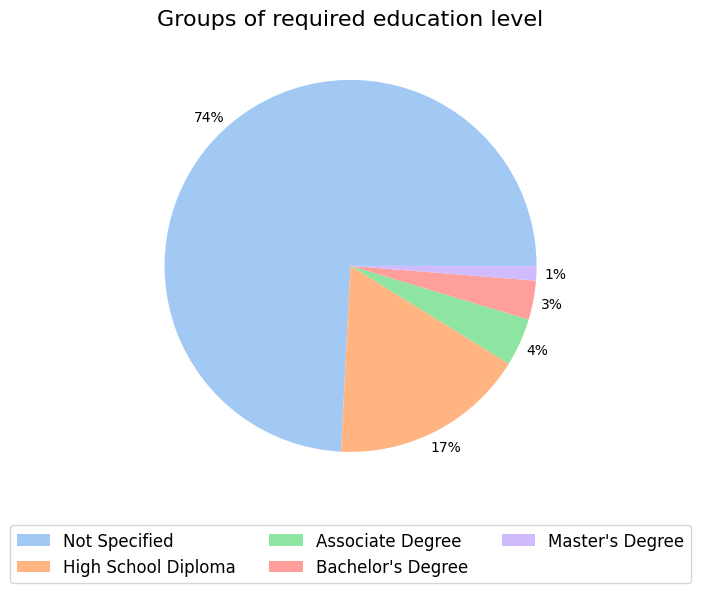

In [26]:
"""
Let's check unique categories in Education.Required column in details
"""
edu_level = job_description["Education.Required"].value_counts().reset_index()
edu_level.columns = ["Education.Required", "count"]

#define Seaborn color palette to use
colors = sns.color_palette("pastel")

#create pie chart
plt.figure(facecolor='white', figsize=(6,8))
plt.pie(edu_level["count"], colors = colors, autopct="%.0f%%", pctdistance=1.1)
plt.title("Groups of required education level", fontsize=16)
plt.legend(edu_level["Education.Required"], loc="upper center", bbox_to_anchor=(0.5, -0.04), ncol=3, fontsize=12)

plt.show()

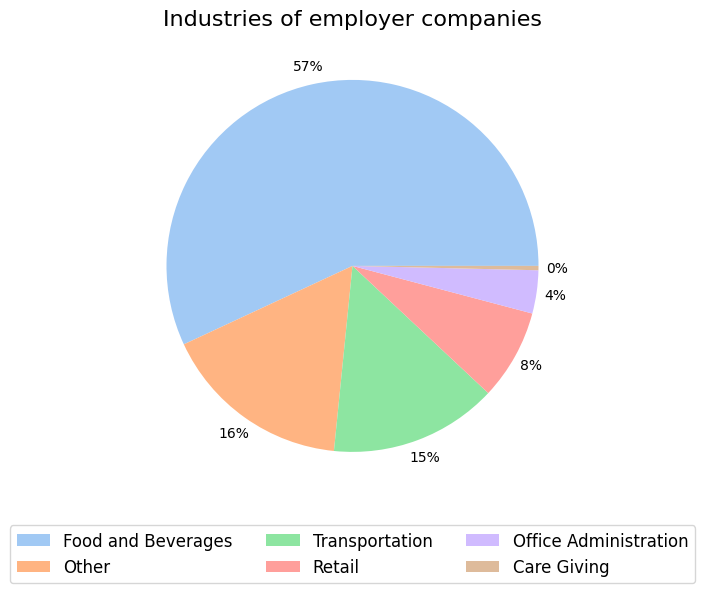

In [27]:
"""
Let's check unique categories in Industry column in details
"""
industry = job_description["Industry"].value_counts().reset_index()
industry.columns = ["Industry", "count"]

#define Seaborn color palette to use
colors = sns.color_palette("pastel")

#create pie chart
plt.figure(facecolor='white', figsize=(6,8))
plt.pie(industry["count"], colors=colors, autopct="%.0f%%", pctdistance=1.1)
plt.title("Industries of employer companies", fontsize=16)
plt.legend(industry["Industry"], loc="upper center", bbox_to_anchor=(0.5, -0.04), ncol=3, fontsize=12)

plt.show()

In [28]:
"""
Let's check unique categories in Employment.Type column in details
"""
round(job_description["Employment.Type"].value_counts(normalize=True), 2)

Employment.Type
Part-Time              0.40
Seasonal/Temp          0.33
Full-Time/Part-Time    0.21
Per Diem               0.06
Intern                 0.01
Full-Time              0.00
Contract               0.00
Temporary/seasonal     0.00
Name: proportion, dtype: float64

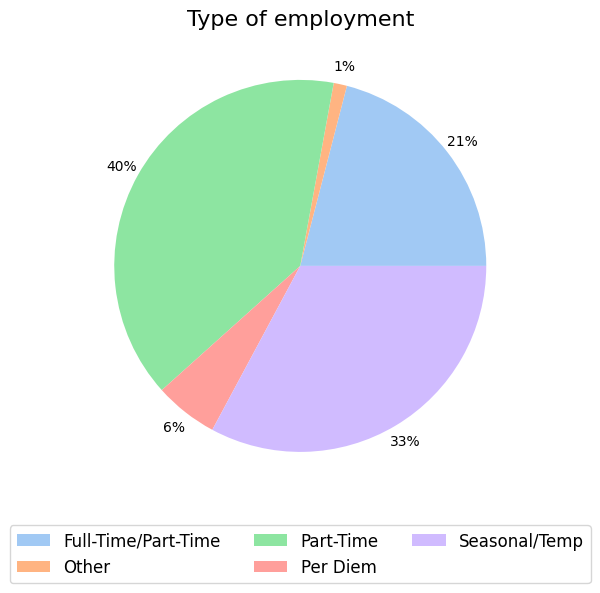

In [29]:
# replacing "Temporary/seasonal" value to "Seasonal/Temp" in type of employment column
job_description.loc[:, "Employment.Type"] = job_description["Employment.Type"].replace(["Temporary/seasonal"], "Seasonal/Temp")

# getting temp df with counts of Employment.Type
employment_type = job_description["Employment.Type"].value_counts().reset_index()
employment_type.columns = ["Employment.Type", "count"]

# getting popular types of employment (taggig unpopular as "other")
popular_emp_type = employment_type[employment_type["count"] >= 1000]["Employment.Type"].tolist()
employment_type["Employment.Type"] = employment_type["Employment.Type"].apply(lambda x: x if x in popular_emp_type else "Other")

# aggregate the same values into one
employment_type = employment_type.groupby(["Employment.Type"])["count"].sum().reset_index()

#define Seaborn color palette to use
colors = sns.color_palette("pastel")

#create pie chart
plt.figure(facecolor='white', figsize=(6,8))
plt.pie(employment_type["count"], colors = colors, autopct="%.0f%%", pctdistance=1.1)
plt.title("Type of employment", fontsize=16)
plt.legend(employment_type["Employment.Type"], loc="upper center", bbox_to_anchor=(0.5, -0.04), ncol=3, fontsize=12)

plt.show()

count    229.000000
mean       7.832227
std        7.566016
min        0.000000
25%        0.000000
50%        8.000000
75%       10.550000
max       58.000000
Name: Salary, dtype: float64

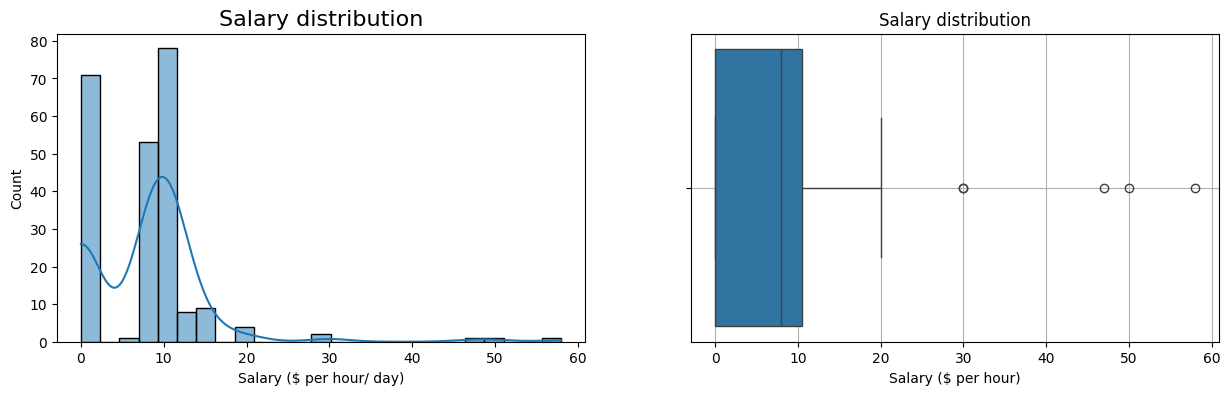

In [30]:
"""
Let's check the distribution of Salary
"""
# coordinate systems visualization
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# create histogram
sns.histplot(
    job_description["Salary"],
    bins=25,
    kde=True,
    ax=axes[0]
);
axes[0].set_title("Salary distribution", fontsize=16);
axes[0].set_xlabel("Salary ($ per hour/ day)")

# create boxplot
sns.boxplot(
    job_description["Salary"],
    orient="h",
    width=0.9,
    ax=axes[1]
);
axes[1].set_title("Salary distribution");
axes[1].set_xlabel("Salary ($ per hour)");
axes[1].grid()

job_description["Salary"].describe()

In [31]:
"""
Let's check unique categories in Position column in details
"""
job_description["Position"].value_counts()

Position
Administrative Assistant                                                      1414
Customer Service Representative                                               1296
Accounts Payable Clerk                                                         970
Accounting Clerk                                                               953
Sales Representative / Sales Associate ( Entry Level )                         917
                                                                              ... 
Medical Records Clerk - Home Health - PRN - Kindred at Home - Campbell, CA       1
Immediate Need for Accounts Receivable Clerk                                     1
Financial Operations Consultant                                                  1
AR Clerk with Cash Applications experience needed Downtown                       1
Book Keeper                                                                      1
Name: count, Length: 36245, dtype: int64

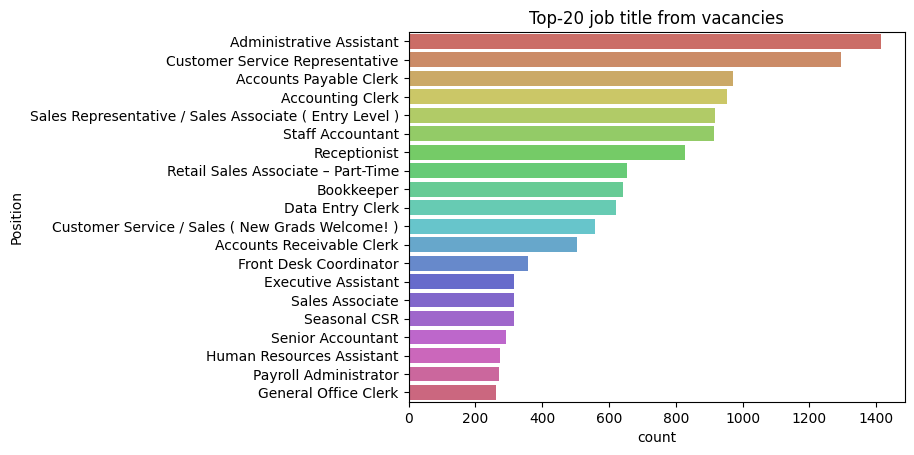

In [32]:
job_title = job_description["Position"].value_counts().reset_index()[:20]
job_title.columns = ["Position", "count"]

sns.barplot(x="count", y="Position", data=job_title, color="blue", palette="hls").set(title="Top-20 job title from vacancies");

In [33]:
"""
Let's check unique categories in State.Name and State.Code columns in details
"""
state_name_code = job_description.groupby("State.Code")["State.Name"].value_counts().reset_index(name="count").sort_values(["count"], ascending=False).reset_index()
state_name_code.drop("index", axis=1)

,State.Code,State.Name,count
0,CA,California,10755
1,FL,Florida,5683
2,TX,Texas,5479
3,PA,Pennsylvania,4972
4,IL,Illinois,4081
5,OH,Ohio,4047
6,NY,New York,3243
7,NJ,New Jersey,2869
8,MN,Minnesota,2476
9,IN,Indiana,2420


In [34]:
"""
Let's check unique categories in City column in details
"""
city_by_state = job_description.groupby("State.Code")["City"].value_counts().reset_index(name="count")

print(f"\nNumber of cities from different states: {city_by_state.shape[0]}\n")
display(city_by_state[:10])


Number of cities from different states: 7203



,State.Code,City,count
0,AK,Anchorage,87
1,AK,Fairbanks,15
2,AK,Kodiak,9
3,AK,Juneau,5
4,AK,Wasilla,4
5,AK,Valdez,4
6,AK,Soldotna,4
7,AK,Fort Wainwright,3
8,AK,Bethel,3
9,AK,Kotzebue,3


In [35]:
# Checking for duplicate city names from different states
cities = city_by_state.groupby(["City"])["State.Code"].nunique().reset_index()
townships = cities[cities["State.Code"] != 1]

print(f"\nNumber of cities-townships: {townships.shape[0]}\n")
display(townships[:10])


Number of cities-townships: 870



,City,State.Code
0,Abbeville,2
2,Aberdeen,5
3,Abilene,2
4,Abingdon,2
9,Acton,3
11,Ada,2
16,Addison,3
20,Adrian,2
30,Akron,3
37,Alamo,2


In [36]:
"""
Let's check unique categories in Company column in details
"""
company_by_state = job_description.groupby("State.Code")["Company"].value_counts().reset_index(name="count")

print(f"\nNumber of companies from different states: {company_by_state.shape[0]}\n")
display(company_by_state[:10])


Number of companies from different states: 15566



,State.Code,Company,count
0,AK,Providence Health & Services,36
1,AK,Swedish Health,31
2,AK,Alaska Airlines,10
3,AK,"The Geo Group, Inc.",10
4,AK,Vector Marketing,9
5,AK,SAS Retail Services,6
6,AK,First Student,6
7,AK,Transportation Security Administration,6
8,AK,KeyBank,4
9,AK,Charter College,4


In [37]:
# Checking for duplicate company names from different states
companies = company_by_state.groupby(["Company"])["State.Code"].nunique().reset_index()
duplicated_name_of_company = companies[companies["State.Code"] != 1]

print(f"\nNumber of companies with the same name from different states: {duplicated_name_of_company.shape[0]}\n")
display(duplicated_name_of_company[:20])


Number of companies with the same name from different states: 1502



,Company,State.Code
8,1st Class Staffing,2
11,"20/20 Companies, Inc.",3
14,"2020 Companies, Inc.",2
16,24 Seven Inc,3
18,360 Healthcare Staffing,11
20,5 Entry Level Openings!,2
24,84 Lumber,21
36,A+E Networks,2
38,A-Line Staffing Solutions.,2
44,AAA,2


The following is a pretty neat way to visualize the distribution of missing values in the dataset.

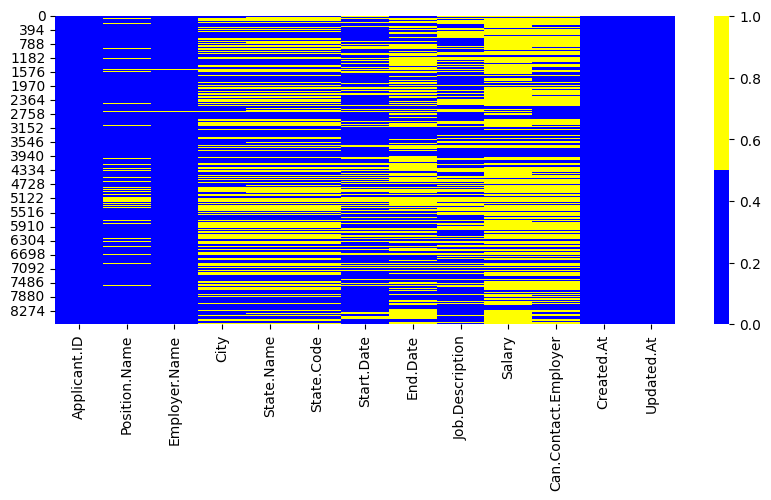

In [38]:
"""
Distribution of Missing Values according to the data
"""
cols_with_null = resumes.isnull().sum()

colors = ["blue", "yellow"]

fig = plt.figure(figsize=(10,4))
cols = cols_with_null.index
ax = sns.heatmap(
    resumes[cols].isnull(),
    cmap=sns.color_palette(colors)
)